In [48]:
# import libaries

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchinfo import summary
from torchvision import transforms
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, ReLU6, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
from statistics import mean

import datetime
import os

from sklearn.model_selection import KFold, train_test_split


In [139]:
print('Python version:', sys.version)
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    print('GPU Name:', torch.cuda.get_device_name())
    print('GPU Properties:\n', torch.cuda.get_device_properties('cuda'))
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.95, 0)
    torch.cuda.empty_cache()
else:
    print("Cuda is not available, please use cpu instead")
    device = "cpu"
!nvidia-smi

Python version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070
GPU Properties:
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)
Wed Mar 22 00:31:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    27W / 175W |   1255Mi

In [50]:
seed = 41
img_size = 112

In [51]:
# Define custom dataset
class FaceDataset(Dataset):
    def __init__(self, df, train, num_sample = None, transform = None, num_img_pool = 10, ):
        # set random seed for FaceDataset
        np.random.seed(seed)
        random.seed(seed)
        # create constructors
        self.unique_img_name = None
        self.train = train
        self.data = dict()
        self.images = list()
        # label to indices
        # self.label_to_indices = dict()
        self.labels = list()
        # read csv file
        self.df = df
        # set the transformation
        self.transform = transform
        # drop last n row from dataframe
        self.df = self.df.head(num_sample)
        #get the length of entire dataset
        self.len_ = len(self.df)
        if num_sample is None or num_sample > self.len_:
            num_sample = self.len_
        # load imgs
        self.load_imgs(self.df, num_imgs = num_img_pool, max = num_sample)

    def __len__(self):
        return self.len_

    # get each pair of images -> 1: same identity, 0: different identity
    # if index is even -> same pair
    # if index is odd -> random identity
    def __getitem__(self, idx):
        if self.train:
            anchor_img = self.images[idx]
            anchor_label = self.labels[idx]
            pos_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
            neg_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

            pos_img = self.images[pos_idx]
            neg_img = self.images[neg_idx]

            pos_label = self.labels[pos_idx]
            neg_label = self.labels[neg_idx]

            if self.transform is None:
                img_to_tensor = transforms.ToTensor()
                anchor_img = img_to_tensor(anchor_img)
                pos_img = img_to_tensor(pos_img)
                neg_img = img_to_tensor(neg_img)
            else:
                anchor_img = self.transform(anchor_img)
                pos_img = self.transform(pos_img)
                neg_img = self.transform(neg_img)
            return anchor_img, pos_img, neg_img

        else:
            label = False
            anchor_img = self.images[idx]
            anchor_label = self.labels[idx]
            if idx % 2 == 0:
                test_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
                label = True

            else:
                test_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

            test_img = self.images[test_idx]

            if self.transform is None:
                img_to_tensor = transforms.ToTensor()
                anchor_img = img_to_tensor(anchor_img)
                test_img = img_to_tensor(test_img)

            else:
                anchor_img = self.transform(anchor_img)
                test_img = self.transform(test_img)

            return anchor_img, test_img, label

    # load imgs from pandas to memory and define the maximum number of images
    def load_imgs(self, df, num_imgs, max):
        # iterate thought each row
        for i, row in tqdm(df.iterrows(), total = max):
            # get identity of each row
            row_identity = row['identity']
            # append each identity to numberical value
            # self.label_to_indices[int(row_identity)] = i
            count_img = 0
            # loop imgs in each identity
            for img_name in row['path']:
                if count_img > num_imgs:
                    break
                # concatenate the directoru and image name
                # path_to_image = self.dir+img_name
                path_to_image = img_name
                # open image and convert to RGB
                img = Image.open(path_to_image).convert('RGB')

                self.images.append(img)
                self.labels.append(i)
                count_img += 1  # print('Added img '+ str(row_identity))
        self.labels = np.array(self.labels)

In [52]:
ds_df = pd.read_csv('./digiface_csv_files/digi_all.csv')
# ds_df = pd.read_csv('./csv_files/lfw_ds.csv')
ds_df = ds_df.groupby('identity')['path'].apply(list).reset_index()
ds_df

,identity,path
0,0,"[digiFace1M\subjects_0-1999_72_imgs\0\20.png, ..."
1,1,"[digiFace1M\subjects_0-1999_72_imgs\1\66.png, ..."
2,2,"[digiFace1M\subjects_0-1999_72_imgs\2\29.png, ..."
3,3,"[digiFace1M\subjects_0-1999_72_imgs\3\42.png, ..."
4,4,"[digiFace1M\subjects_0-1999_72_imgs\4\33.png, ..."
...,...,...
72661,199994,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72662,199995,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72663,199996,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72664,199997,[digiFace1M\subjects_166666-199998_5_imgs\1999...


In [6]:
ds_df

,identity,path
0,0,"[digiFace1M\subjects_0-1999_72_imgs\0\20.png, ..."
1,1,"[digiFace1M\subjects_0-1999_72_imgs\1\66.png, ..."
2,2,"[digiFace1M\subjects_0-1999_72_imgs\2\29.png, ..."
3,3,"[digiFace1M\subjects_0-1999_72_imgs\3\42.png, ..."
4,4,"[digiFace1M\subjects_0-1999_72_imgs\4\33.png, ..."
...,...,...
72661,199994,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72662,199995,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72663,199996,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72664,199997,[digiFace1M\subjects_166666-199998_5_imgs\1999...


In [7]:

# splitting each dataset
train_df, eval_df = train_test_split(ds_df, test_size = 0.3, shuffle = True, random_state = seed)
val_df, test_df = train_test_split(eval_df, test_size = 0.4, shuffle = True, random_state = seed)

# print to check size of each dataset
print(f'Train Size: {len(train_df)}')
print(f'Val Size: {len(val_df)}')
print(f'Test Size: {len(test_df)}')

train_df.head(5)

Train Size: 50866
Val Size: 13080
Test Size: 8720


,identity,path
26344,120344,[digiFace1M\subjects_100000-133332_5_imgs\1203...
61833,189166,[digiFace1M\subjects_166666-199998_5_imgs\1891...
46921,174254,[digiFace1M\subjects_166666-199998_5_imgs\1742...
4873,8873,[digiFace1M\subjects_8000-9999_72_imgs\8873\54...
19875,113875,[digiFace1M\subjects_100000-133332_5_imgs\1138...


In [8]:
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output


class h_sigmoid(Module):
    def __init__(self, inplace = True):
        super(h_sigmoid, self).__init__()
        self.relu = ReLU6(inplace = inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(Module):
    def __init__(self, inplace = True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace = inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(Module):
    def __init__(self, channel, reduction = 4):
        super(SELayer, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc = Sequential(Linear(channel, channel // reduction), ReLU(inplace = True),
                             Linear(channel // reduction, channel), h_sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class PermutationBlock(Module):
    def __init__(self, groups):
        super(PermutationBlock, self).__init__()
        self.groups = groups

    def forward(self, input):
        n, c, h, w = input.size()
        G = self.groups
        output = input.view(n, G, c // G, h, w).permute(0, 2, 1, 3, 4).contiguous().view(n, c, h, w)
        return output


class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x


class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Depth_Wise(Module):
    def __init__(self, in_c, out_c, residual = False, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c = groups, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.conv_dw = Conv_block(groups, groups, groups = groups, kernel = kernel, padding = padding, stride = stride)
        self.project = Linear_block(groups, out_c, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.residual = residual

    def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output


class Residual(Module):
    def __init__(self, c, num_block, groups, kernel = (3, 3), stride = (1, 1), padding = (1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(
                Depth_Wise(c, c, residual = True, kernel = kernel, padding = padding, stride = stride, groups = groups))
        self.model = Sequential(*modules)

    def forward(self, x):
        return self.model(x)


class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start = start_value, stop = stop_value, num = nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1


class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input = mask[:, None, :, :], kernel_size = (
            self.block_size, self.block_size), stride = (1, 1), padding = self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


In [137]:

class MobileFaceNet(Module):
    def __init__(self, embedding_size = 512):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel = (3, 3), stride = (1, 1), padding = (1, 1), groups = 64)
        self.conv_23 = Depth_Wise(64, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 128)
        self.conv_3 = Residual(64, num_block = 4, groups = 128, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 256)
        self.conv_4 = Residual(128, num_block = 6, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 512)
        self.conv_5 = Residual(128, num_block = 2, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel = (1, 1), stride = (1, 1), padding = (0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups = 512, kernel = (7, 7), stride = (1, 1), padding = (0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias = False)
        self.bn = BatchNorm1d(embedding_size)
        self.dropblock = DropBlock2D(block_size = 3, drop_prob = 0.3)
        self.dropout = Dropout(0.1)

    def forward_once(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.dropblock(out)

        out = self.conv_6_dw(out)

        out = self.dropblock(out)

        out = self.conv_6_flatten(out)

        out = self.dropout(out)

        out = self.linear(out)

        out = self.bn(out)

        return l2_norm(out)

    def forward(self, img):
        anchor = self.forward_once(img)
        return anchor



In [138]:
triplet_model = MobileFaceNet()
print(summary(triplet_model, input_size = [(32, 3, 112, 112)]))

Layer (type:depth-idx)                        Output Shape              Param #
MobileFaceNet                                 [32, 512]                 --
├─Conv_block: 1-1                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-1                            [32, 64, 56, 56]          1,728
│    └─BatchNorm2d: 2-2                       [32, 64, 56, 56]          128
│    └─PReLU: 2-3                             [32, 64, 56, 56]          64
├─Conv_block: 1-2                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-4                            [32, 64, 56, 56]          576
│    └─BatchNorm2d: 2-5                       [32, 64, 56, 56]          128
│    └─PReLU: 2-6                             [32, 64, 56, 56]          64
├─Depth_Wise: 1-3                             [32, 64, 28, 28]          --
│    └─Conv_block: 2-7                        [32, 128, 56, 56]         --
│    │    └─Conv2d: 3-1                       [32, 128, 56, 56]         8,192
│    │    └

In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average = True):
        # calculate Euclidean's distance
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)

        losses = F.relu(distance_positive - distance_negative + self.margin)

        return torch.mean(losses)

In [12]:
model_config = {
    'margin': 1.2,
    'lr': 1e-3,
    'patience': 5,
    'factor': 0.1,
    'min_lr': 1e-10,
    'threshold': 1e-3
    }
criterion = TripletLoss(margin = model_config['margin'])
optimizer = optim.Adam(triplet_model.parameters(), lr = model_config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = model_config['patience'],
                                                 factor = model_config['factor'], min_lr = model_config['min_lr'],
                                                 threshold = model_config['threshold'], verbose = True)

In [13]:
def calculate_accuracy(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_positives = np.sum(np.logical_and(predict_issame, actual_issame))
    false_positives = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    true_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    # For dealing with Divide By Zero exception
    true_positive_rate = 0 if (true_positives + false_negatives == 0) else float(true_positives) / float(
        true_positives + false_negatives)

    false_positive_rate = 0 if (false_positives + true_negatives == 0) else float(false_positives) / float(
        false_positives + true_negatives)

    precision = 0 if (true_positives + false_positives) == 0 else float(true_positives) / float(
        true_positives + false_positives)

    recall = 0 if (true_positives + false_negatives) == 0 else float(true_positives) / float(
        true_positives + false_negatives)

    accuracy = float(true_positives + true_negatives) / dist.size

    #     return true_positive_rate, false_positive_rate, precision, recall, accuracy
    return [true_positive_rate, false_positive_rate, accuracy]

In [15]:
# define transformation for test set
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.CenterCrop(img_size),
                                      transforms.RandomHorizontalFlip(p = 0.6),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.5, 0.5, 0.5],
                                                           std = [0.5, 0.5, 0.5])
                                      ])
# define transformation for validation set
val_transform = transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.CenterCrop(img_size),
                                    transforms.ToTensor()
                                    ])

In [77]:
def train_model(model, train_loader, train_optimizer, train_criterion, weight_path = None):
    train_loss = 0
    train_accuracy = list()
    # applied weight
    if weight_path != None:
        model.load_state_dict(weight_path)
    # set to train mode
    model.train()
    # loop though loader
    with torch.set_grad_enabled(True):
        for anchor_img, pos_img, neg_img in tqdm(train_loader):
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)

            # throw img to CUDA
            anchor_img, pos_img, neg_img = anchor_img.to(device), pos_img.to(device), neg_img.to(device)
            # prevent grad vansishing
            train_optimizer.zero_grad()
            # training model
            # anchor_img, pos_img, neg_img = model(anchor_img, pos_img,neg_img)
            anchor_out = model(anchor_img)
            pos_out = model(pos_img)
            neg_out = model(neg_img)
            # calculate loss
            loss = train_criterion.forward(anchor_out, pos_out, neg_out)
            # backpropragation
            loss.backward()
            # compute gradient
            train_optimizer.step()
            # compute train loss
            train_loss += loss.item() * anchor_img.size(0)
    # test_acc, distances, labels =test_model(model, train_loader)

    return train_loss


def test_model(model, test_loader, weight_path: str = None):
    test_accuracy = list()
    label_s = list()
    distance_s = list()
    distances_hist = list()
    if weight_path is not None:
        model.load_state_dict(torch.load(weight_path))
    # set to train mode
    model.eval()
    # enable grad
    with torch.no_grad():
        # loop though loader
        for index, (anchor_img, test_img, label) in enumerate(test_loader):
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)
            # throw img to CUDA
            anchor_img, pos_img = anchor_img.to(device), test_img.to(device)
            # compute distance from model
            anchor_out = model(anchor_img)
            pos_out = model(pos_img)
            # calculate distance between anchor and test images
            distance_val = (anchor_out - pos_out).pow(2).sum(1)
            # append label coordinate with each testing pair
            label_s.append(label.cpu().data.numpy())
            distance_s.append(distance_val.cpu().data.numpy())

        labels_hist = [sub_label for each_label in label_s for sub_label in each_label]
        distance_hist = [sub_distance for each_distance in distance_s for sub_distance in each_distance]

        test_accuracy.append(calculate_accuracy(np.full(np.size(distance_hist),
                                                        model_config['margin']), np.array(distance_hist), labels_hist)[
                                 2])
    return mean(test_accuracy), distance_hist, labels_hist


In [33]:
cross_val_train_dataset = FaceDataset(df = train_df, train = True, num_sample = 10000, transform = train_transform)
cross_val_val_dataset = FaceDataset(df = val_df, train = False, num_sample = 3000, transform = val_transform)
train_batch_size = 64
val_batch_size = 64

train_triplet_dataloader = DataLoader(cross_val_train_dataset, batch_size = train_batch_size, shuffle = True,
                                      pin_memory = True)
val_triplet_dataloader = DataLoader(cross_val_val_dataset, batch_size = val_batch_size, shuffle = True,
                                    pin_memory = True)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [46]:
# save the model weight
def save_weight(custom_name: str, model, csv_file: str):
    # check csv file exist 
    if not os.path.exists(csv_file):
        # create new csv_file
        pd.DataFrame(columns = ['date_added', 'path']).to_csv(csv_file)
    # read csv file    
    weight_df = pd.read_csv(csv_file)

    datetime_now = str(datetime.datetime.now())
    save_path = './weights/' + custom_name + datetime_now[:-7].replace('-', '').replace(':', '') + '.pth'

    # create dataframe
    temp_df = pd.DataFrame([[datetime_now, save_path]], columns = ['date_added', 'path'])
    weight_df = pd.concat([weight_df, temp_df], axis = 0, ignore_index = True).drop(['Unnamed: 0'], axis = 1)
    weight_df = weight_df[['date_added', 'path']]
    # save csv 
    weight_df.to_csv(csv_file)
    # save weight 
    save_weight_path = save_path
    torch.save(model.state_dict(), save_weight_path)
    print('Save Success! @' + datetime_now + ' in ' + save_path)
    return save_path


# get the latest weight
def get_latest_weight(csv_path: str) -> str:
    # read csv file
    weight_df = pd.read_csv(csv_path)
    # convert object to datetime type
    weight_df['date_added'] = pd.to_datetime(weight_df['date_added'])
    # sorting date
    weight_df = weight_df.sort_values(by = 'date_added', ascending = False)
    # get latest item
    latest_record = weight_df.head(1)
    print('It was saved at ' + str(latest_record['date_added'].values[0]))
    return weight_df['path'].head(1).values[0]

In [47]:
get_latest_weight('./csv_files/weight_records.csv')

It was saved at 2023-03-21T22:27:46.155612000


'./weights/mobile_network_120_updated20230321 222746.pth'

In [35]:
num_epoch = 120
previous_lr = 0
hist_epoch_train_loss = list()
hist_epoch_train_acc = list()
hist_epoch_val_acc = list()

for epoch in tqdm(range(num_epoch)):
    # train model
    epoch_train_loss = train_model(triplet_model, train_triplet_dataloader, optimizer, criterion)
    # validate model
    epoch_val_acc, epoch_distances, epoch_labels = test_model(triplet_model, val_triplet_dataloader)
    # compute loss
    train_loss = epoch_train_loss / len(train_triplet_dataloader.sampler)
    # update scheduler
    scheduler.step(train_loss)

    hist_epoch_train_loss.append(train_loss)
    hist_epoch_val_acc.append(epoch_val_acc)

    # get the learning rate
    optim_lr = optimizer.param_groups[0]['lr']
    if (optim_lr < previous_lr) | (optim_lr > previous_lr):
        print('LEARNING RATE HAS CHANGED!')
    # update learning rate to temp variable
    previous_lr = optim_lr
    # observe status
    print(
        f' Epoch {epoch + 1}/{num_epoch},Learning rate: {optim_lr}, train loss: {round(train_loss, 5)}, val acc: {round(epoch_val_acc, 5)}')
save_path = save_weight(custom_name = 'mobile_network_120_updated', model = triplet_model,
                        csv_file = './csv_files/weight_records.csv')


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
 Epoch 1/120,Learning rate: 0.001, train loss: 0.70447, val acc: 0.73367


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 2/120,Learning rate: 0.001, train loss: 0.5399, val acc: 0.77133


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 3/120,Learning rate: 0.001, train loss: 0.48792, val acc: 0.776


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 4/120,Learning rate: 0.001, train loss: 0.45564, val acc: 0.781


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 5/120,Learning rate: 0.001, train loss: 0.41045, val acc: 0.802


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 6/120,Learning rate: 0.001, train loss: 0.39165, val acc: 0.81233


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 7/120,Learning rate: 0.001, train loss: 0.38851, val acc: 0.821


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 8/120,Learning rate: 0.001, train loss: 0.36421, val acc: 0.81733


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 9/120,Learning rate: 0.001, train loss: 0.36338, val acc: 0.83167


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 10/120,Learning rate: 0.001, train loss: 0.35604, val acc: 0.82867


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 11/120,Learning rate: 0.001, train loss: 0.33438, val acc: 0.833


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 12/120,Learning rate: 0.001, train loss: 0.32294, val acc: 0.845


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 13/120,Learning rate: 0.001, train loss: 0.31804, val acc: 0.85333


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 14/120,Learning rate: 0.001, train loss: 0.31368, val acc: 0.856


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 15/120,Learning rate: 0.001, train loss: 0.30418, val acc: 0.84833


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 16/120,Learning rate: 0.001, train loss: 0.30281, val acc: 0.845


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 17/120,Learning rate: 0.001, train loss: 0.30008, val acc: 0.84933


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 18/120,Learning rate: 0.001, train loss: 0.29632, val acc: 0.856


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 19/120,Learning rate: 0.001, train loss: 0.28623, val acc: 0.85467


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 20/120,Learning rate: 0.001, train loss: 0.27457, val acc: 0.854


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 21/120,Learning rate: 0.001, train loss: 0.26196, val acc: 0.85333


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 22/120,Learning rate: 0.001, train loss: 0.26834, val acc: 0.84533


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 23/120,Learning rate: 0.001, train loss: 0.26129, val acc: 0.86067


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 24/120,Learning rate: 0.001, train loss: 0.2556, val acc: 0.86


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 25/120,Learning rate: 0.001, train loss: 0.25358, val acc: 0.85633


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 26/120,Learning rate: 0.001, train loss: 0.25941, val acc: 0.86833


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 27/120,Learning rate: 0.001, train loss: 0.25964, val acc: 0.85767


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 28/120,Learning rate: 0.001, train loss: 0.24707, val acc: 0.86367


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 29/120,Learning rate: 0.001, train loss: 0.24008, val acc: 0.85967


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 30/120,Learning rate: 0.001, train loss: 0.2417, val acc: 0.87667


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 31/120,Learning rate: 0.001, train loss: 0.24965, val acc: 0.87333


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 32/120,Learning rate: 0.001, train loss: 0.23163, val acc: 0.87433


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 33/120,Learning rate: 0.001, train loss: 0.22565, val acc: 0.872


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 34/120,Learning rate: 0.001, train loss: 0.23405, val acc: 0.86967


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 35/120,Learning rate: 0.001, train loss: 0.22697, val acc: 0.87033


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 36/120,Learning rate: 0.001, train loss: 0.22849, val acc: 0.881


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 37/120,Learning rate: 0.001, train loss: 0.21802, val acc: 0.87767


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 38/120,Learning rate: 0.001, train loss: 0.21643, val acc: 0.88167


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 39/120,Learning rate: 0.001, train loss: 0.21071, val acc: 0.86667


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 40/120,Learning rate: 0.001, train loss: 0.22028, val acc: 0.88067


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 41/120,Learning rate: 0.001, train loss: 0.21018, val acc: 0.886


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 42/120,Learning rate: 0.001, train loss: 0.2111, val acc: 0.876


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 43/120,Learning rate: 0.001, train loss: 0.20664, val acc: 0.88533


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 44/120,Learning rate: 0.001, train loss: 0.20893, val acc: 0.87733


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 45/120,Learning rate: 0.001, train loss: 0.20214, val acc: 0.88067


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 46/120,Learning rate: 0.001, train loss: 0.20886, val acc: 0.86667


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 47/120,Learning rate: 0.001, train loss: 0.19681, val acc: 0.87533


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 48/120,Learning rate: 0.001, train loss: 0.19873, val acc: 0.87933


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 49/120,Learning rate: 0.001, train loss: 0.19049, val acc: 0.88633


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 50/120,Learning rate: 0.001, train loss: 0.1895, val acc: 0.88767


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 51/120,Learning rate: 0.001, train loss: 0.19069, val acc: 0.88067


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 52/120,Learning rate: 0.001, train loss: 0.18894, val acc: 0.889


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 53/120,Learning rate: 0.001, train loss: 0.19289, val acc: 0.881


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 54/120,Learning rate: 0.001, train loss: 0.18862, val acc: 0.89167


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 55/120,Learning rate: 0.001, train loss: 0.18996, val acc: 0.88333


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 56/120,Learning rate: 0.001, train loss: 0.18476, val acc: 0.88333


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 57/120,Learning rate: 0.001, train loss: 0.18464, val acc: 0.886


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 58/120,Learning rate: 0.001, train loss: 0.18598, val acc: 0.881


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 59/120,Learning rate: 0.001, train loss: 0.18356, val acc: 0.884


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 60/120,Learning rate: 0.001, train loss: 0.1777, val acc: 0.89833


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 61/120,Learning rate: 0.001, train loss: 0.17565, val acc: 0.89


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 62/120,Learning rate: 0.001, train loss: 0.18037, val acc: 0.89167


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 63/120,Learning rate: 0.001, train loss: 0.17916, val acc: 0.885


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 64/120,Learning rate: 0.001, train loss: 0.16995, val acc: 0.88867


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 65/120,Learning rate: 0.001, train loss: 0.17342, val acc: 0.89167


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 66/120,Learning rate: 0.001, train loss: 0.17158, val acc: 0.88133


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 67/120,Learning rate: 0.001, train loss: 0.17251, val acc: 0.89033


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 68/120,Learning rate: 0.001, train loss: 0.17044, val acc: 0.887


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 69/120,Learning rate: 0.001, train loss: 0.15899, val acc: 0.895


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 70/120,Learning rate: 0.001, train loss: 0.16012, val acc: 0.88967


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 71/120,Learning rate: 0.001, train loss: 0.16094, val acc: 0.89667


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 72/120,Learning rate: 0.001, train loss: 0.16868, val acc: 0.89367


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 73/120,Learning rate: 0.001, train loss: 0.15953, val acc: 0.88933


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 74/120,Learning rate: 0.001, train loss: 0.1555, val acc: 0.89367


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 75/120,Learning rate: 0.001, train loss: 0.15426, val acc: 0.892


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 76/120,Learning rate: 0.001, train loss: 0.15606, val acc: 0.88467


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 77/120,Learning rate: 0.001, train loss: 0.15309, val acc: 0.896


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 78/120,Learning rate: 0.001, train loss: 0.15796, val acc: 0.89133


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 79/120,Learning rate: 0.001, train loss: 0.15357, val acc: 0.902


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 80/120,Learning rate: 0.001, train loss: 0.14839, val acc: 0.89767


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 81/120,Learning rate: 0.001, train loss: 0.15241, val acc: 0.886


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 82/120,Learning rate: 0.001, train loss: 0.15305, val acc: 0.89133


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 83/120,Learning rate: 0.001, train loss: 0.1489, val acc: 0.90433


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 84/120,Learning rate: 0.001, train loss: 0.14499, val acc: 0.89833


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 85/120,Learning rate: 0.001, train loss: 0.14192, val acc: 0.89967


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 86/120,Learning rate: 0.001, train loss: 0.14542, val acc: 0.89567


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 87/120,Learning rate: 0.001, train loss: 0.15014, val acc: 0.90033


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 88/120,Learning rate: 0.001, train loss: 0.13939, val acc: 0.89633


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 89/120,Learning rate: 0.001, train loss: 0.14201, val acc: 0.89267


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 90/120,Learning rate: 0.001, train loss: 0.14545, val acc: 0.902


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 91/120,Learning rate: 0.001, train loss: 0.145, val acc: 0.89467


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 92/120,Learning rate: 0.001, train loss: 0.13757, val acc: 0.89467


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 93/120,Learning rate: 0.001, train loss: 0.14222, val acc: 0.88867


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 94/120,Learning rate: 0.001, train loss: 0.1343, val acc: 0.90267


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 95/120,Learning rate: 0.001, train loss: 0.13888, val acc: 0.90467


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 96/120,Learning rate: 0.001, train loss: 0.13632, val acc: 0.887


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 97/120,Learning rate: 0.001, train loss: 0.13174, val acc: 0.891


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 98/120,Learning rate: 0.001, train loss: 0.14107, val acc: 0.90433


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 99/120,Learning rate: 0.001, train loss: 0.1375, val acc: 0.89767


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 100/120,Learning rate: 0.001, train loss: 0.13586, val acc: 0.90633


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 101/120,Learning rate: 0.001, train loss: 0.13496, val acc: 0.899


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 102/120,Learning rate: 0.001, train loss: 0.13662, val acc: 0.89967


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.
LEARNING RATE HAS CHANGED!
 Epoch 103/120,Learning rate: 0.0001, train loss: 0.13178, val acc: 0.90933


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 104/120,Learning rate: 0.0001, train loss: 0.12654, val acc: 0.907


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 105/120,Learning rate: 0.0001, train loss: 0.11337, val acc: 0.90667


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 106/120,Learning rate: 0.0001, train loss: 0.11371, val acc: 0.91167


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 107/120,Learning rate: 0.0001, train loss: 0.11181, val acc: 0.90567


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 108/120,Learning rate: 0.0001, train loss: 0.11144, val acc: 0.909


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 109/120,Learning rate: 0.0001, train loss: 0.11345, val acc: 0.91467


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 110/120,Learning rate: 0.0001, train loss: 0.10974, val acc: 0.90967


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 111/120,Learning rate: 0.0001, train loss: 0.10766, val acc: 0.90767


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 112/120,Learning rate: 0.0001, train loss: 0.11289, val acc: 0.915


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 113/120,Learning rate: 0.0001, train loss: 0.11489, val acc: 0.908


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 114/120,Learning rate: 0.0001, train loss: 0.1088, val acc: 0.902


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 115/120,Learning rate: 0.0001, train loss: 0.10612, val acc: 0.90633


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 116/120,Learning rate: 0.0001, train loss: 0.11018, val acc: 0.91533


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 117/120,Learning rate: 0.0001, train loss: 0.10049, val acc: 0.91467


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 118/120,Learning rate: 0.0001, train loss: 0.10078, val acc: 0.90133


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 119/120,Learning rate: 0.0001, train loss: 0.09971, val acc: 0.90967


  0%|          | 0/157 [00:00<?, ?it/s]

 Epoch 120/120,Learning rate: 0.0001, train loss: 0.10324, val acc: 0.90433
Save Success! @2023-03-21 22:27:46.155612 in ./weights/mobile_network_120_updated20230321 222746.pth


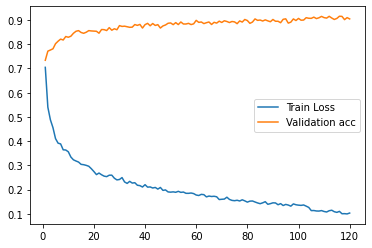

In [37]:
plt.plot(np.arange(1, len(hist_epoch_train_loss) + 1), hist_epoch_train_loss, label = 'Train Loss')
plt.plot(np.arange(1, len(hist_epoch_val_acc) + 1), hist_epoch_val_acc, label = 'Validation acc')
plt.legend()
plt.show()

# Cross Validation

In [19]:
num_epoch = 130
previous_lr = 0
history_train = {
    'train_loss': dict(),
    'val_loss': dict(),
    'train_acc': dict(),
    'val_acc': dict()
    }
split = 1
k_fold = KFold(n_splits = split, shuffle = True, random_state = seed)
batch_size = 64
for fold, (train_idx, valid_idx) in tqdm(enumerate(k_fold.split(cross_val_train_dataset)), total = split):
    triplet_model = MobileFaceNet()

    triplet_model.to(device)
    model_config = {
        'margin': 1.2,
        'lr': 1e-3,
        'patience': 7,
        'factor': 0.1,
        'min_lr': 1e-10,
        'threshold': 1e-3
        }
    criterion = TripletLoss(margin = model_config['margin'])
    optimizer = optim.Adam(triplet_model.parameters(), lr = model_config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = model_config['patience'], factor =
    model_config['factor'], min_lr = model_config['min_lr'], threshold = model_config['threshold'], verbose = True)
    print(f'Fold: {fold}/{split}')

    # the number of epoch in each fold
    # Random get the sample from dataset
    train_subsampler = torch.utils.data.Subset(cross_val_train_dataset, train_idx)
    valid_subsampler = torch.utils.data.Subset(cross_val_val_dataset, valid_idx)

    # Load data into dataloader
    train_loader = DataLoader(train_subsampler, batch_size = batch_size, shuffle = True, pin_memory = True)
    valid_loader = DataLoader(valid_subsampler, batch_size = batch_size, shuffle = True, pin_memory = True)

    hist_epoch_train_loss = list()
    hist_epoch_train_acc = list()
    hist_epoch_val_acc = list()

    for epoch in tqdm(range(num_epoch)):
        # train model
        epoch_train_loss, train_acc = train_model(triplet_model, train_loader, optimizer, criterion)
        # validate model
        epoch_val_acc, epoch_distances, epoch_labels = test_model(triplet_model, valid_loader)
        # compute loss
        train_loss = epoch_train_loss / len(train_loader.sampler)
        # update scheduler
        scheduler.step(train_loss)

        hist_epoch_train_loss.append(train_loss)
        hist_epoch_train_acc.append(train_acc)
        hist_epoch_val_acc.append(epoch_val_acc)

        # get the learning rate
        optim_lr = optimizer.param_groups[0]['lr']
        if (optim_lr < previous_lr) | (optim_lr > previous_lr):
            print('LEARNING RATE HAS CHANGED!')
        # update learning rate to temp variable
        previous_lr = optim_lr
        # observe status
        print(
            f'Fold: {fold + 1}/{split}, Epoch {epoch + 1}/{num_epoch},Learning rate: {optim_lr}, train loss: {round(train_loss, 5)}, train acc: {round(train_acc, 5)}, val acc: {round(epoch_val_acc, 5)}')

    # append historical data
    history_train['train_loss'][fold] = hist_epoch_train_loss

    history_train['train_acc'][fold] = hist_epoch_train_acc
    history_train['val_acc'][fold] = hist_epoch_val_acc

    print(f'Average result {fold + 1}/{split}, Avg train loss:', mean(
        history_train['train_loss'][fold]), 'Avg Val loss:', mean(
        history_train['val_loss'][fold]), 'avg train acc:', mean(
        history_train['train_acc'][fold]), 'avg val acc:', mean(history_train['val_acc'][fold]))
    # clear GPU memory allocated
    torch.cuda.empty_cache()

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [187]:
torch.cuda.empty_cache()

In [92]:

avg_train_loss = list()
avg_val_loss = list()
avg_train_acc = list()
avg_val_acc = list()

for i in range(1):
    avg_train_loss.extend(history_train['train_loss'][i])
    #     avg_val_loss.extend(history_train['val_loss'][i])
    #     avg_train_acc.extend(history_train['train_acc'][i])
    avg_val_acc.extend(history_train['val_acc'][i])

# print(mean(avg_train_loss))
print(
    f'avg train loss: {round(mean(avg_train_loss), 4)}, avg val loss: {round(mean(avg_val_loss), 4)}, avg train acc: {round(mean(avg_train_acc), 4)}, avg val acc: {round(mean(avg_val_acc), 4)}')

NameError: name 'history_train' is not defined

In [89]:
plt.plot(np.arange(1, len(history_train['train_loss'][0]) + 1), history_train['train_loss'][0], label = 'Train Loss')
# plt.plot(np.arange(1, len(history_train['val_loss'][0]) + 1), history_train['val_loss'][0], label='Validation loss')
# plt.plot(np.arange(1, len(history_train['train_acc'][0]) + 1), history_train['train_acc'][0], label='Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][0]) + 1), history_train['val_acc'][0], label = 'Validation acc')
plt.legend()
plt.show()

NameError: name 'history_train' is not defined

In [ ]:
plt.plot(np.arange(1, len(history_train['train_loss'][1]) + 1), history_train['train_loss'][1], label = 'Train Loss')
# plt.plot(np.arange(1, len(history_train['val_loss'][1]) + 1), history_train['val_loss'][1], label='Validation loss')
plt.plot(np.arange(1, len(history_train['train_acc'][1]) + 1), history_train['train_acc'][1], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][1]) + 1), history_train['val_acc'][1], label = 'Validation acc')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(1, len(history_train['train_loss'][2]) + 1), history_train['train_loss'][2], label = 'Train Loss')
# plt.plot(np.arange(1, len(history_train['val_loss'][2]) + 1), history_train['val_loss'][2], label='Validation loss')
plt.plot(np.arange(1, len(history_train['train_acc'][2]) + 1), history_train['train_acc'][2], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][2]) + 1), history_train['val_acc'][2], label = 'Validation acc')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(1, len(history_train['train_loss'][3]) + 1), history_train['train_loss'][3], label = 'Train Loss')
# plt.plot(np.arange(1, len(history_train['val_loss'][3]) + 1), history_train['val_loss'][3], label='Validation loss')
plt.plot(np.arange(1, len(history_train['train_acc'][3]) + 1), history_train['train_acc'][3], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][3]) + 1), history_train['val_acc'][3], label = 'Validation acc')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(1, len(history_train['train_loss'][4]) + 1), history_train['train_loss'][4], label = 'Train Loss')
# plt.plot(np.arange(1, len(history_train['val_loss'][4]) + 1), history_train['val_loss'][4], label='Validation loss')
plt.plot(np.arange(1, len(history_train['train_acc'][4]) + 1), history_train['train_acc'][4], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][4]) + 1), history_train['val_acc'][4], label = 'Validation acc')
plt.legend()
plt.show()

In [81]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    ])

# define batch size for testing
test_batch_size = 64
# create dataloader for validation set
test_triplet_dataset = FaceDataset(df = test_df, train = False, num_sample = 2000, transform = test_transform)
test_triplet_dataloader = DataLoader(test_triplet_dataset, batch_size = test_batch_size, shuffle = True,
                                     pin_memory = True)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [82]:
# get the latest weight
latest_weight_path = get_latest_weight('./csv_files/weight_records.csv')

acc, distances, labels = test_model(MobileFaceNet().to(device), test_triplet_dataloader, latest_weight_path)

It was saved at 2023-03-21T22:27:46.155612000


In [134]:
calculate_accuracy(np.full(np.size(np.array(distances)), model_config['threshold']), np.array(distances), labels)

[0.219, 0.0, 0.6095]